# Title
---
* **`OBJECTIVE`**

  * Brief description of the objective of the model/analysis.


* **`KPIs`**

  List all key performance indicators. For example:

  * Model predicts **X**...
  * Further actions need to be taken to acquire data for the model.
  * Out of sample predictions show that...
  * **Y** is an outlier when these assumptions are made...

**This should be easy to consume, and suitable for an executive to understand**
**in less than a few minutes. Structuring the notebook in this way, should help**
**build a story about the analysis and the model.**

# Notebook specifics
---
Below is everything done to generate the data story above. Everything done should
relate to the KPIs and show evidence for any insights.

## Notebook imports, constants, accessors, _etc_

In [1]:
%matplotlib inline

import gzip
import io
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
from bokeh.io import output_notebook
from bokeh.layouts import column
from bokeh.models import Band, ColumnDataSource, HoverTool, NumeralTickFormatter, Select
from bokeh.plotting import figure, gridplot, show
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler
from s3fs import S3FileSystem
from sklearn.datasets import load_iris
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, learning_curve, ShuffleSplit, train_test_split
from sklearn.naive_bayes import GaussianNB


RANDOM_STATE = 42
output_notebook()

Loading BokehJS ...

## Data set generation
* **`DATA SOURCES`**

  List all data sources, _e.g._. This should help you understand what data can
  be used for the analysis/model, and how to ultimately do the ETL for the
  model.

  * rexdb
  * Insightly
  * Web events


* **`PROVENANCE`**

  Here we will refer to the excellent work done by Dong Huynh,
  http://trungdong.github.io/prov-python-short-tutorial.html. Basically you need
  to show _and store_ the following things about the notebook/models.

  * Entity

    * An entity is a physical, digital, conceptual, or other kind of thing
      with some fixed aspects; entities may be real or imaginary.

  * Activity

    * An activity is something that occurs over a period of time and acts upon
      or with entities; it may include consuming, processing, transforming,
      modifying, relocating, using, or generating entities.

  * Agent

    * An agent is something that bears some form of responsibility for an
      activity taking place, for the existence of an entity, or for another
      agent's activity.


Below we will work through an example where we extract, transform, and load
data for a model using the Entity, Activity and Agent work flow.

**`NOTE`** Adding more metadata around the actual person that has created the
model, as well as the date with which the model was generated is also a good
idea. We do not add that information below, but it is a good idea to do so.
Also including a unique identifier for the model will help with best practices
when building data sets and models.

### Data set provenance model

In [2]:
class Extract:
    """This is an example of an Agent. This object is going to be a recipe
    for the extraction of data. It will not do anything by itself, since the
    extraction is done through the _extract method that must be written by a
    class that inherits this object.
    """

    def _extract(self, *args, **kwargs):
        raise NotImplementedError('To be implemented by the inheriting class.')

    def extract(self, *args, **kwargs):
        extracted_data = self._extract(*args, **kwargs)
        return extracted_data

In [3]:
class Transform:
    """This is another Agent that we will use to transform any extracted data."""

    def _transform(self, *args, **kwargs):
        raise NotImplementedError('To be implemented by the inheriting class.')

    def transform(self, *args, **kwargs):
        transformed_data = self._transform(*args, **kwargs)
        return transformed_data

In [4]:
class Load:
    """Just as in the Extract and Transform objects, we create a Load object
    that is a yet another Agent. We will use this data loading object to build
    another data set object that will be used to create entities for our
    model(s).
    """

    def _load(self, *args, **kwargs):
        raise NotImplementedError('To be implemented by the inheriting class.')

    def load(self, *args, **kwargs):
        loaded_data = self._load(*args, **kwargs)
        return loaded_data

In [5]:
class CSVDataSet:
    """This example will show how to persist a data set locally and on S3. This
    is an Agent that orchestrates the loading of data set and the
    creation of the data set object.

    Again, this object will not do anything useful since it requires bucket
    names and file names to be created, as well as the _load method.
    """

    name = None
    data_set_name = None
    data_set_file_extension = 'csv'
    file_compression = 'gz'
    data_set_file_name = None
    bucket_local = None
    bucket_remote = None
    bucket_prefix = None
    data_set_path_local = None
    data_set_path_remote = None
    s3 = S3FileSystem()

    def generate_names_with_cache_paths(self):
        self.name = f'{self.__class__.__name__}'
        self.data_set_name = f'{self.name}'
        self.data_set_file_name = (
            f'{self.data_set_name}'
            f'.{self.data_set_file_extension}'
            f'.{self.file_compression}'
        )
        self.data_set_path_local = os.path.join(
            self.bucket_local,
            self.data_set_file_name,
        )
        if not os.path.exists(os.path.dirname(self.data_set_path_local)):
            os.makedirs(os.path.dirname(self.data_set_path_local))
        self.data_set_path_remote = os.path.join(
            's3://',
            self.bucket_remote,
            self.bucket_prefix,
            self.data_set_file_name,
        )

    def cache_df(self, df, where):
        print(f'Caching data set {where}.')
        data_set_buffer = io.StringIO()
        df.to_csv(data_set_buffer, index=False)
        data_set_buffer.seek(0)
        gzipped_data_set_buffer = io.BytesIO()
        with gzip.GzipFile(mode='w', fileobj=gzipped_data_set_buffer) as file_:
            file_.write(bytes(data_set_buffer.getvalue(), 'utf-8'))

        if where == 'locally':
            with open(self.data_set_path_local, 'wb') as file_:
                file_.write(gzipped_data_set_buffer.getvalue())

        elif where == 'remotely':
            with self.s3.open(self.data_set_path_remote, 'wb') as file_:
                file_.write(gzipped_data_set_buffer.getvalue())

    def _load_data_set(self, *args, **kwargs):
        if 'overwrite_cache' in kwargs:
            overwrite_cache = kwargs.get('overwrite_cache', False)
        else:
            overwrite_cache = False

        data_set_exists_locally = os.path.exists(self.data_set_path_local)
        data_set_exists_remotely = self.s3.exists(self.data_set_path_remote)
        data_does_not_exists = (
            not data_set_exists_locally
            and not data_set_exists_remotely
        )

        if data_set_exists_locally:
            print('Loading the data set from the local cache.')
            self.df = pd.read_csv(self.data_set_path_local, low_memory=False)
            if not data_set_exists_remotely:
                self.cache_df(df=self.df, where='remotely')

        elif data_set_exists_remotely:
            print('Loading the data set from the remote cache.')
            self.df = pd.read_csv(self.data_set_path_remote, low_memory=False)
            if not data_set_exists_locally:
                self.cache_df(df=self.df, where='locally')

        elif overwrite_cache or data_does_not_exists:
            print('(Re)building data set.')
            self.df = self._load(*args, **kwargs)
            self.cache_df(df=self.df, where='locally')
            self.cache_df(df=self.df, where='remotely')

    def load_data_set(self, *args, **kwargs):
        self._load_data_set(*args, **kwargs)

    def is_data_set_cached(self):
        return not self.df.empty

### Data set implementation
Below is an example of how to execute the Data Entity/Activity/Agent ETL
process specifically using the Iris data set from `sklearn`.

In [6]:
class IrisDataExtractor(Extract):
    """This is an example of an Activity. It will require the inheritance of
    the agent called Extract. Here we will write the actual extraction of the
    data. This object could perform the generation of an Entity, if the
    extraction is a time-consuming process.
    """

    def _extract(self):
        iris_data = load_iris()
        return iris_data

In [7]:
class IrisDataTransformer(Transform):
    """As was done with the data extraction, here we will write the data
    transformation. This is another example of an Activity. It should be
    noted that this is not a generic transformation class. It is dependent
    on the extracted Iris data set. If you make this class a generic data
    transformation, then you need to make sure that any assumptions about the
    model are described further in the process. Making this "generic" could be
    useful if you need to make many models with different assumptions in them
    that are all based on the same data.

    If you do not need to make this generic, then it is a good idea to place
    all assumptions about the model and data in this object.
    """

    def _transform(self, data):
        df = pd.DataFrame(
            data=data['data'],
            columns=data['feature_names'],
        )
        name_dict = {i: name for i, name in enumerate(data['target_names'])}
        df['iris_name'] = data['target']
        df['iris_name'] = df['iris_name'].apply(lambda index: name_dict[index])
        return df

In [8]:
class IrisDataLoader(Load):
    """This specific example of an Activity also sets the dataframe attribute
    as an Entity to this object. This may seem unusual right now, but it will
    make sense when used in conjunction with the DataSet object below.
    """

    df = pd.DataFrame()

    def _load(self):
        extractor = IrisDataExtractor()
        extracted_data = extractor.extract()
        transformer = IrisDataTransformer()
        transformed_data = transformer.transform(extracted_data)
        self.df = transformed_data.copy()
        return self.df

In [9]:
class IrisDataSet(CSVDataSet, IrisDataLoader):

    bucket_local = '../data/'
    bucket_remote = 'org-rex-data'
    bucket_prefix = 'research/rex-analysis/amaloney'

    def __init__(self):
        self.generate_names_with_cache_paths()

### The actual ETL process
We will copy the dataframe into a variable so that we can do some exploratory
data analysis in the notebook.

In [10]:
iris_ds = IrisDataSet()
iris_ds.load_data_set()
iris_df = iris_ds.df.copy()

Loading the data set from the remote cache.
Caching data set locally.


## Data exploration
Exploratory data analysis includes many different things. This is where we pull
out our toolbox of statistics, visualizations and information theoretic measures
to help us understand where the model or analysis should proceed next. This
section may or may not be useful for the executive, but it will always be
beneficial for you as you build the data story.

### Visuals
Sometimes visualizing data will help you to understand more about the data.
There are tools you can use to quickly visualize statistical measures, and
how the data are distributed. A great number of these tool exist in seaborn,
but bokeh also has some interesting interactivity capabilities.

#### seaborn

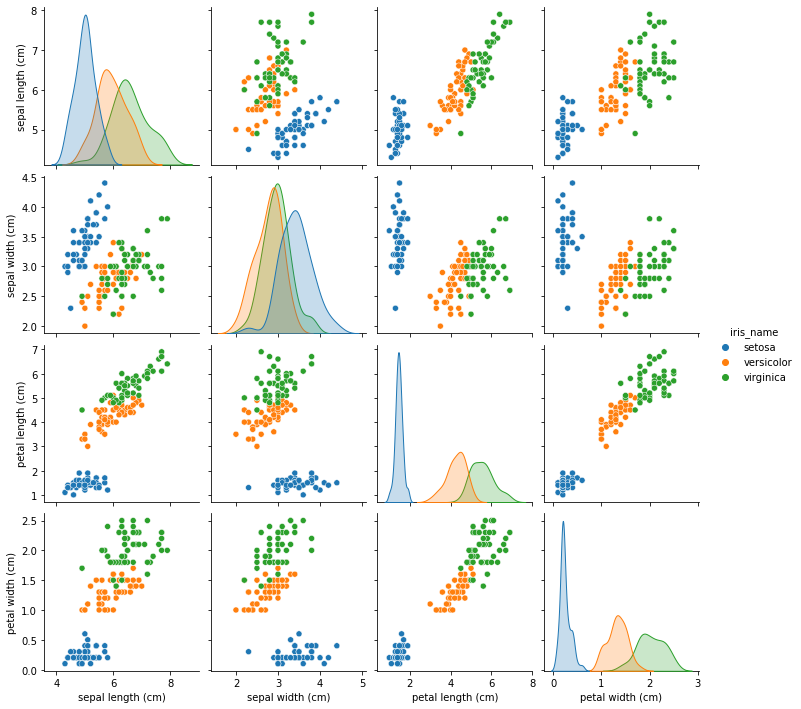

In [11]:
sns.pairplot(iris_df, hue='iris_name')

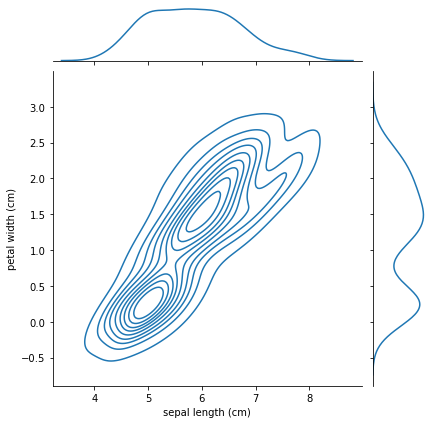

In [12]:
sns.jointplot(
    x='sepal length (cm)',
    y='petal width (cm)',
    data=iris_df,
    kind='kde',
)

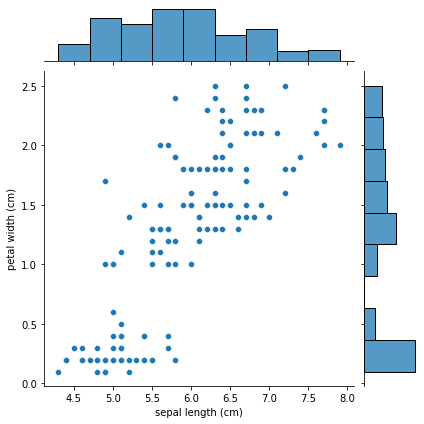

In [13]:
sns.jointplot(
    x='sepal length (cm)',
    y='petal width (cm)',
    data=iris_df,
)

/Users/aterrel/miniforge3/envs/nb_rubric/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='petal length (cm)', ylabel='Density'>

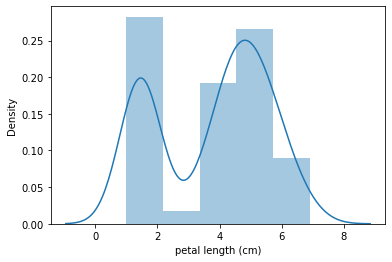

In [14]:
sns.distplot(iris_df['petal length (cm)'])

/Users/aterrel/miniforge3/envs/nb_rubric/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/aterrel/miniforge3/envs/nb_rubric/lib/python3.8/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='petal length (cm)', ylabel='Density'>

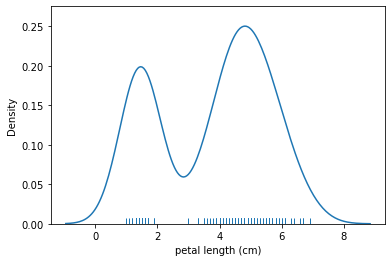

In [15]:
sns.distplot(iris_df['petal length (cm)'], rug=True, hist=False)

In [16]:
iris_df.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'iris_name'],
      dtype='object')

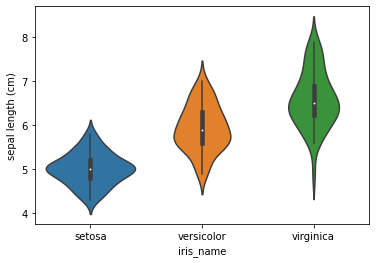

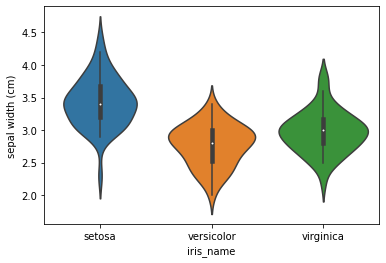

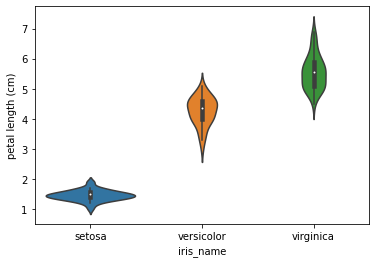

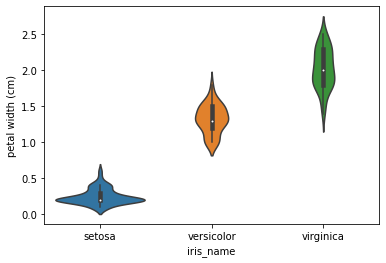

In [17]:
for column in iris_df.select_dtypes(float).columns:
    f = plt.figure()
    sns.violinplot(x='iris_name', y=column, data=iris_df)

#### bokeh
Above are shown several plots using the seaborn package. Most of these figures can be
done in bokeh, which has the ability to make more interactive plots. The advantage of using
seaborn and matplotlib is that you do not need a jupyter server running to see the
visualizations. **But** you will need a jupyter server running if you want to see the
below bokeh rendering.

The amount of code required to build this visual is a lot more than seaborn,
but it might help you understand the data better since you can see tooltips
and other things.

In [19]:
# Define filters and features for the data to be plotted
category = 'setosa'
y_feature = 'sepal width (cm)'
x_feature = 'petal length (cm)'

# Define plot styles and annotations
scatter_plot_height = 400
scatter_plot_width = 700
x_feature_plot_height = 200
x_feature_plot_width = scatter_plot_width
y_feature_plot_height = scatter_plot_height
y_feature_plot_width = x_feature_plot_height
fill_color = 'steelblue'
line_color = 'steelblue'
line_width = 2.0
line_alpha = 0.5
fill_alpha = 0.6
dmass = 0.05

# Define the plots
scatter_plot = figure(
    plot_width=scatter_plot_width,
    plot_height=scatter_plot_height,
    x_axis_label=x_feature,
    y_axis_label=y_feature,
)
x_feature_plot = figure(
    plot_width=x_feature_plot_width,
    plot_height=x_feature_plot_height,
    x_range=scatter_plot.x_range,
)
y_feature_plot = figure(
    plot_width=y_feature_plot_width,
    plot_height=y_feature_plot_height,
    y_range=scatter_plot.y_range,
)

# Prepare the data to be plotted
data_df = iris_df[
    (iris_df['iris_name'] == category)
    & (iris_df[y_feature].notnull())
    & (iris_df[x_feature].notnull())
].reset_index(drop=True).copy()

x_feature_data = data_df[x_feature].astype(float).values
x_feature_kde = sm.nonparametric.KDEUnivariate(x_feature_data)
x_feature_kde.fit()
x_feature_counts, x_feature_bins = np.histogram(x_feature_data, bins=20)
x_feature_pdf = (x_feature_kde.density / x_feature_kde.density.max()) * max(x_feature_counts)
x_feature_source = ColumnDataSource({'x': x_feature_kde.support, 'y': x_feature_pdf})
x_feature_cdf = x_feature_kde.cdf
x_feature_cdf = x_feature_cdf / x_feature_cdf.max()
x_feature_start_index = (np.abs(x_feature_cdf - dmass)).argmin()
x_feature_end_index = (np.abs(x_feature_cdf - (1 - dmass))).argmin()
x_feature_lower_x = x_feature_kde.support[x_feature_start_index:x_feature_end_index]
x_feature_upper_x = x_feature_lower_x[::-1]
x_feature_lower_y = np.zeros(x_feature_pdf[x_feature_start_index:x_feature_end_index].size)
x_feature_upper_y = x_feature_pdf[x_feature_start_index:x_feature_end_index]
x_feature_patch_source = ColumnDataSource(
    {
        'xs': [np.hstack((x_feature_lower_x, x_feature_upper_x))],
        'ys': [np.hstack((x_feature_upper_y, x_feature_lower_y))],
    }
)

y_feature_data = data_df[y_feature].astype(float).values
y_feature_kde = sm.nonparametric.KDEUnivariate(y_feature_data)
y_feature_kde.fit()
y_feature_counts, y_feature_bins = np.histogram(y_feature_data, bins=20)
y_feature_pdf = (y_feature_kde.density / y_feature_kde.density.max()) * max(y_feature_counts)
y_feature_source = ColumnDataSource({'x': y_feature_kde.support, 'y': y_feature_pdf})
y_feature_cdf = y_feature_kde.cdf
y_feature_cdf = y_feature_cdf / y_feature_cdf.max()
y_feature_start_index = (np.abs(y_feature_cdf - dmass)).argmin()
y_feature_end_index = (np.abs(y_feature_cdf - (1 - dmass))).argmin()
y_feature_lower_x = y_feature_kde.support[y_feature_start_index:y_feature_end_index]
y_feature_upper_x = y_feature_lower_x[::-1]
y_feature_lower_y = np.zeros(y_feature_pdf[y_feature_start_index:y_feature_end_index].size)
y_feature_upper_y = y_feature_pdf[y_feature_start_index:y_feature_end_index]
y_feature_patch_source = ColumnDataSource(
    {
        'xs': [np.hstack((y_feature_lower_x, y_feature_upper_x))],
        'ys': [np.hstack((y_feature_upper_y, y_feature_lower_y))],
    }
)

data_df['color'] = 'grey'
i = data_df[
    (
        data_df[x_feature].between(
            x_feature_kde.support[x_feature_start_index],
            x_feature_kde.support[x_feature_end_index],)
    )
    & (
        data_df[y_feature].between(
            y_feature_kde.support[y_feature_start_index],
            y_feature_kde.support[y_feature_end_index],
        )
    )
].index
for row_index, row in data_df.iterrows():
    if row_index in i:
        data_df.loc[row_index, 'color'] = 'steelblue'
scatter_plot_color = data_df['color'].values
scatter_source = ColumnDataSource(
    {
        'x': x_feature_data,
        'y': y_feature_data,
        'color': scatter_plot_color,
    }
)


# Bind data to the plot
scatter_glyph = scatter_plot.circle(
    x='x',
    y='y',
    source=scatter_source,
    size=6,
    fill_color='color',
    line_color='white',
    alpha=fill_alpha,
)
x_feature_line = x_feature_plot.line(
    x='x',
    y='y',
    source=x_feature_source,
    line_color=line_color,
    line_width=line_width,
    alpha=line_alpha,
)
x_feature_patch = x_feature_plot.patches(
    xs='xs',
    ys='ys',
    source=x_feature_patch_source,
    fill_color='steelblue',
    line_color='steelblue',
    alpha=0.2,
    hover_fill_color='orange',
    hover_line_color='orange',
    hover_alpha=0.2,
)
y_feature_line = y_feature_plot.line(
    x='y',
    y='x',
    source=y_feature_source,
    line_color=line_color,
    line_width=line_width,
    alpha=line_alpha,
)
y_feature_patch = y_feature_plot.patches(
    xs='ys',
    ys='xs',
    source=y_feature_patch_source,
    fill_color='steelblue',
    line_color='steelblue',
    alpha=0.2,
    hover_fill_color='orange',
    hover_line_color='orange',
    hover_alpha=0.2,
)

# Create annotations
scatter_tooltips = HoverTool(
    renderers=[scatter_glyph],
    tooltips=[(y_feature, '@y'), (x_feature, '@x')]
)
x_feature_line_tooltips = HoverTool(
    renderers=[x_feature_line],
    tooltips=[('Counts', '@y'), (x_feature, '@x')],
)
x_feature_patch_tooltips = HoverTool(
    renderers=[x_feature_patch],
    tooltips=[('Mass', f'{(1 - dmass) * 100}')],
)
y_feature_line_tooltips = HoverTool(
    renderers=[y_feature_line],
    tooltips=[('Counts', '@y'), (y_feature, '@x')],
)
y_feature_patch_tooltips = HoverTool(
    renderers=[y_feature_patch],
    tooltips=[('Mass', f'{(1 - dmass) * 100}')],
)

# Bind annotations to the plot
scatter_plot.add_tools(scatter_tooltips)
x_feature_plot.add_tools(x_feature_line_tooltips)
x_feature_plot.add_tools(x_feature_patch_tooltips)
y_feature_plot.add_tools(y_feature_line_tooltips)
y_feature_plot.add_tools(y_feature_patch_tooltips)

# Style the figure
scatter_plot.grid.grid_line_alpha = 0.2
scatter_plot.grid.grid_line_color = 'grey'
scatter_plot.grid.grid_line_width = 0.3
scatter_plot.outline_line_color = 'black'
scatter_plot.xaxis.minor_tick_line_color = None
scatter_plot.yaxis.minor_tick_line_color = None

x_feature_plot.grid.grid_line_color = None
x_feature_plot.outline_line_color = None
x_feature_plot.axis.visible = False

y_feature_plot.grid.grid_line_color = None
y_feature_plot.outline_line_color = None
y_feature_plot.axis.visible = False

grid = gridplot(
    [
        [x_feature_plot, None],
        [scatter_plot, y_feature_plot]
    ]
)
show(grid)

### Statistics
You can use pandas to print out statistics about your data, which may be helpful for
understanding features, _etc_.

In [20]:
iris_df.describe()

sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)  
count        150.000000  
mean           1.199333  
std            0.762238  
min            0.100000  
25%            0.300000  
50%            1.300000  
75%            1.800000  
max            2.500000

In [21]:
for column in sorted(iris_df.columns):
    display(iris_df[column].value_counts(dropna=False))
    print('-' * 110)

setosa        50
versicolor    50
virginica     50
Name: iris_name, dtype: int64

--------------------------------------------------------------------------------------------------------------


1.5    13
1.4    13
5.1     8
4.5     8
1.3     7
1.6     7
5.6     6
4.0     5
4.9     5
4.7     5
4.8     4
1.7     4
4.4     4
4.2     4
5.0     4
4.1     3
5.5     3
4.6     3
6.1     3
5.7     3
3.9     3
5.8     3
1.2     2
1.9     2
6.7     2
3.5     2
5.9     2
6.0     2
5.4     2
5.3     2
3.3     2
4.3     2
5.2     2
6.3     1
1.1     1
6.4     1
3.6     1
3.7     1
3.0     1
3.8     1
6.6     1
6.9     1
1.0     1
Name: petal length (cm), dtype: int64

--------------------------------------------------------------------------------------------------------------


0.2    29
1.3    13
1.5    12
1.8    12
1.4     8
2.3     8
1.0     7
0.3     7
0.4     7
2.0     6
2.1     6
0.1     5
1.2     5
1.9     5
1.6     4
2.5     3
2.2     3
2.4     3
1.1     3
1.7     2
0.6     1
0.5     1
Name: petal width (cm), dtype: int64

--------------------------------------------------------------------------------------------------------------


5.0    10
6.3     9
5.1     9
6.7     8
5.7     8
5.5     7
5.8     7
6.4     7
6.0     6
4.9     6
6.1     6
5.4     6
5.6     6
6.5     5
4.8     5
7.7     4
6.9     4
5.2     4
6.2     4
4.6     4
7.2     3
6.8     3
4.4     3
5.9     3
6.6     2
4.7     2
7.6     1
7.4     1
4.3     1
7.9     1
7.3     1
7.0     1
4.5     1
5.3     1
7.1     1
Name: sepal length (cm), dtype: int64

--------------------------------------------------------------------------------------------------------------


3.0    26
2.8    14
3.2    13
3.4    12
3.1    11
2.9    10
2.7     9
2.5     8
3.5     6
3.8     6
3.3     6
2.6     5
2.3     4
3.6     4
2.4     3
2.2     3
3.7     3
3.9     2
4.2     1
4.1     1
4.4     1
2.0     1
4.0     1
Name: sepal width (cm), dtype: int64

--------------------------------------------------------------------------------------------------------------


### Correlation (confusion) matrix

<AxesSubplot:>

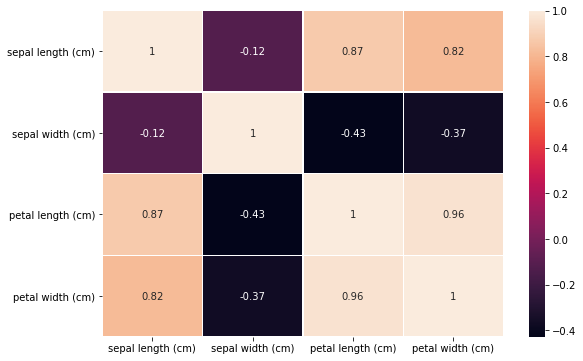

In [22]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(iris_df.corr(), annot=True, linewidths=.5, ax=ax)

### Profiling
If you are wanting to generate a quick overview of a pandas dataframe, then
use the `pandas-profiling` package. Below shows correlations with data, missing
values and a high level overview of the data in the dataframe.

In [24]:
iris_df.profile_report()

### Profiling missing data
There are several different types of missing data. See http://dx.doi.org/10.18637/jss.v045.i03
for a more in depth discussion of different missing data types. Below is a simple
example of how to impute data from a contrived set of data. We will extend this
example to create missing data in the Iris data set, and profile what we did. sklearn
does have an imputation system for multivariate feature sets, see
https://scikit-learn.org/stable/modules/impute.html for more information.

Finally, when building models using missing data it is recommended to profile how a model performs
with imputed missing data. Dillon Niederhut has an excellent talk from SciPy 2018
https://www.youtube.com/watch?v=2gkw2T5jAfo where he discusses model performance using different
types of missing data.

In [25]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit([[1, 2], [np.nan, 3], [7, 6]])
X = [[np.nan, 2], [6, np.nan], [7, 6]]
print(X)
print('-' * 110)
print(imp.transform(X))

[[nan, 2], [6, nan], [7, 6]]
--------------------------------------------------------------------------------------------------------------
[[4.         2.        ]
 [6.         3.66666667]
 [7.         6.        ]]


In [26]:
missing_data_iris_df = iris_df.copy()
columns = missing_data_iris_df.select_dtypes(float).columns
for column in columns:
    n_missing = np.random.choice(range(30, 50))
    indices = np.random.choice(missing_data_iris_df[column].index, n_missing)
    for index in indices:
        missing_data_iris_df.loc[index, column] = np.nan

# Remove any row that unfortunately have all nans
missing_data_iris_df.dropna(subset=columns, how='all')

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               NaN                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               NaN   
3                  NaN               3.1                1.5               0.2   
4                  5.0               NaN                1.4               NaN   
..                 ...               ...                ...               ...   
145                NaN               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               NaN   

     iris_name  
0       setosa  
1       setosa  
2       setosa  
3       setosa  
4       setosa  
..         ...  
145  virginica  
146  virginica  
147  virginica  
148  virginica  
149  virginica  

[149 rows x 5 columns]

Comparing the pair plots for the non-missing data dataframe and the missing data
dataframe we can see that there are shifts in the densities of the data below

In [27]:
missing_data_iris_df.profile_report()

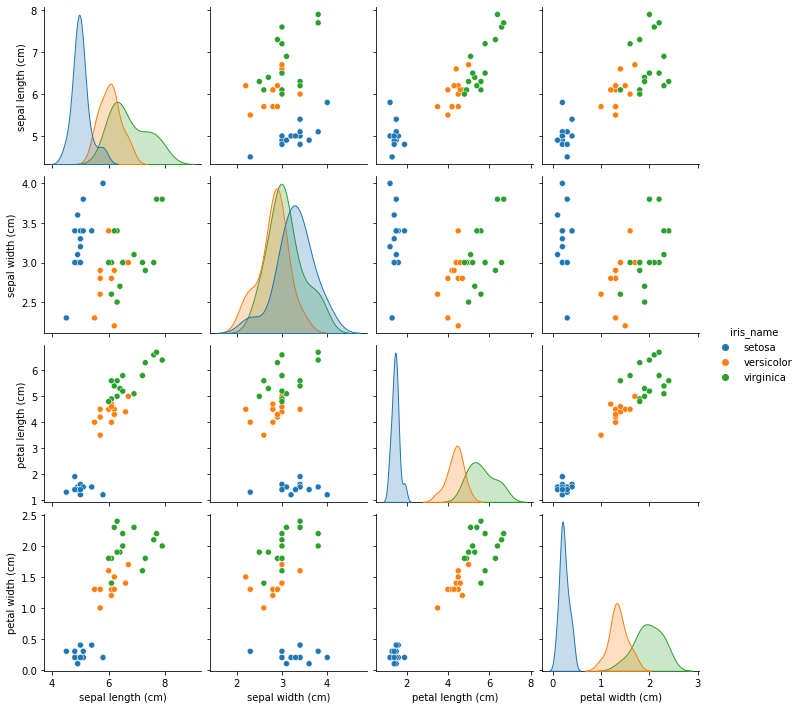

In [28]:
sns.pairplot(missing_data_iris_df.dropna(), hue='iris_name')

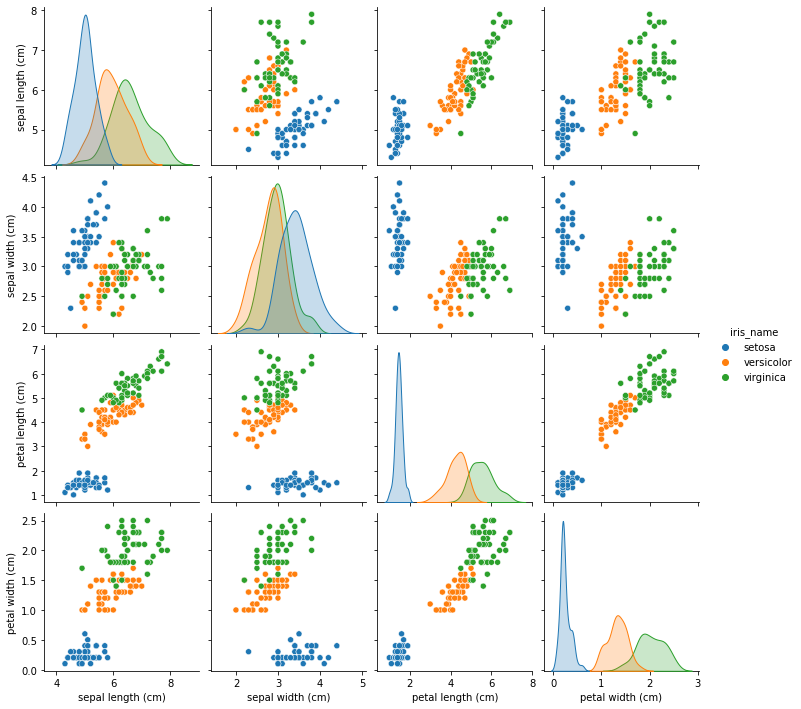

In [29]:
sns.pairplot(iris_df, hue='iris_name')

We will now impute those missing data values and redraw the pairplot to see what
happens when we try and fix missing data values.

In [30]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_data_iris_df = pd.DataFrame(
    data=imp.fit_transform(missing_data_iris_df.select_dtypes(float).values),
    columns=missing_data_iris_df.select_dtypes(float).columns,
)
imputed_data_iris_df['iris_name'] = iris_df['iris_name'].values

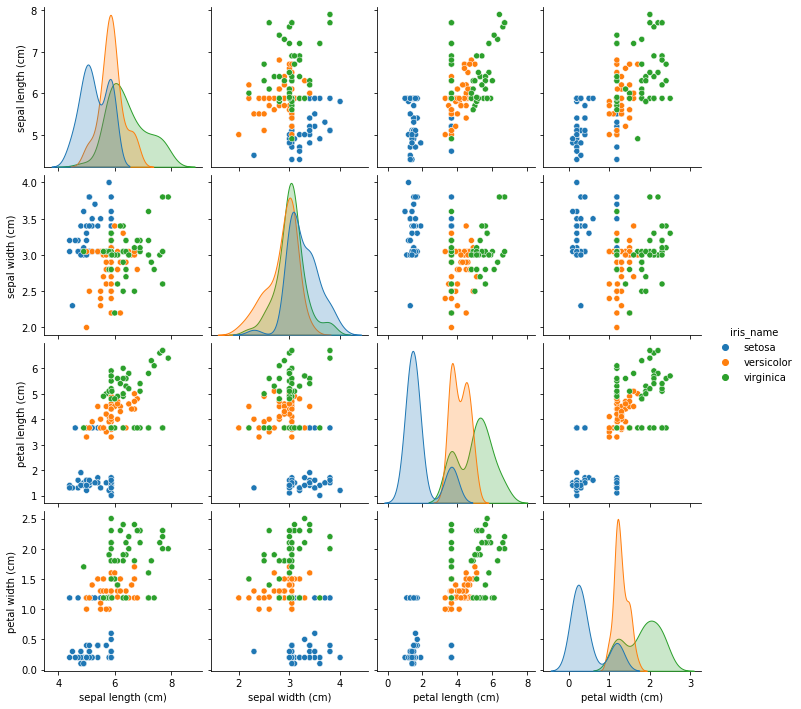

In [31]:
sns.pairplot(imputed_data_iris_df, hue='iris_name')

**`NOTE`**
---
Imputing data using the mean has changed the original data set. Look specifically
at the _setosa_ iris data and how its density has changed as a result of the imputation.
There are other packages that use different imputation methods as described by the `MICE`
paper.

#### K-Nearest Neighbors

In [32]:
# Use 3 nearest rows which have a feature to fill in each row's missing features
knn_imputed_iris_df = pd.DataFrame(
    data=KNN(k=3).fit_transform(missing_data_iris_df.select_dtypes(float).values),
    columns=missing_data_iris_df.select_dtypes(float).columns,
)
knn_imputed_iris_df['iris_name'] = iris_df['iris_name'].values

Imputing row 1/150 with 1 missing, elapsed time: 0.008
Imputing row 101/150 with 2 missing, elapsed time: 0.010
[KNN] Warning: 4/600 still missing after imputation, replacing with 0


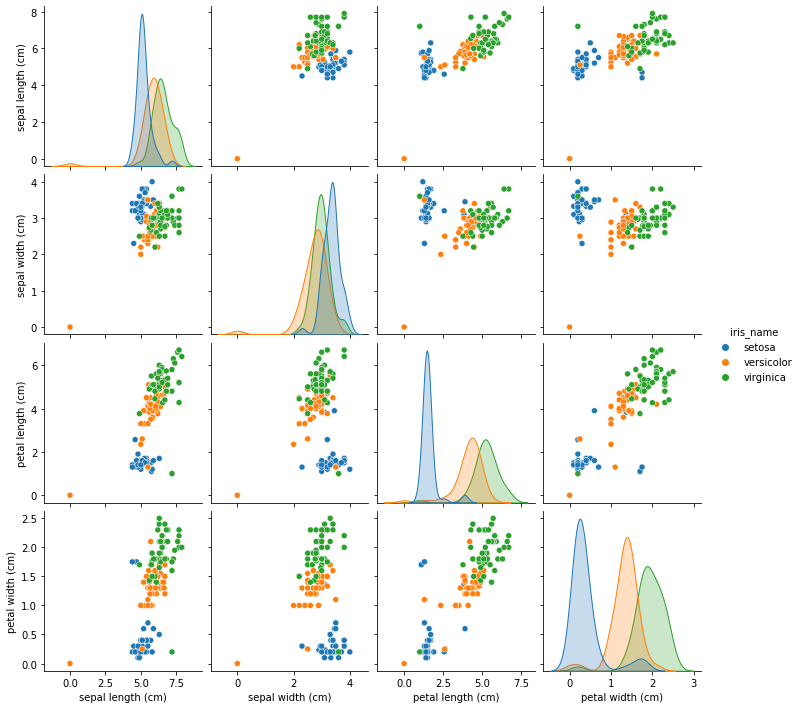

In [33]:
sns.pairplot(knn_imputed_iris_df, hue='iris_name')

#### Convex Optimization

In [34]:
convex_optimization_imputed_iris_df = pd.DataFrame(
    data=NuclearNormMinimization().fit_transform(missing_data_iris_df.select_dtypes(float).values),
    columns=missing_data_iris_df.select_dtypes(float).columns,
)
convex_optimization_imputed_iris_df['iris_name'] = iris_df['iris_name'].values

SolverError: The solver CVXOPT is not installed.

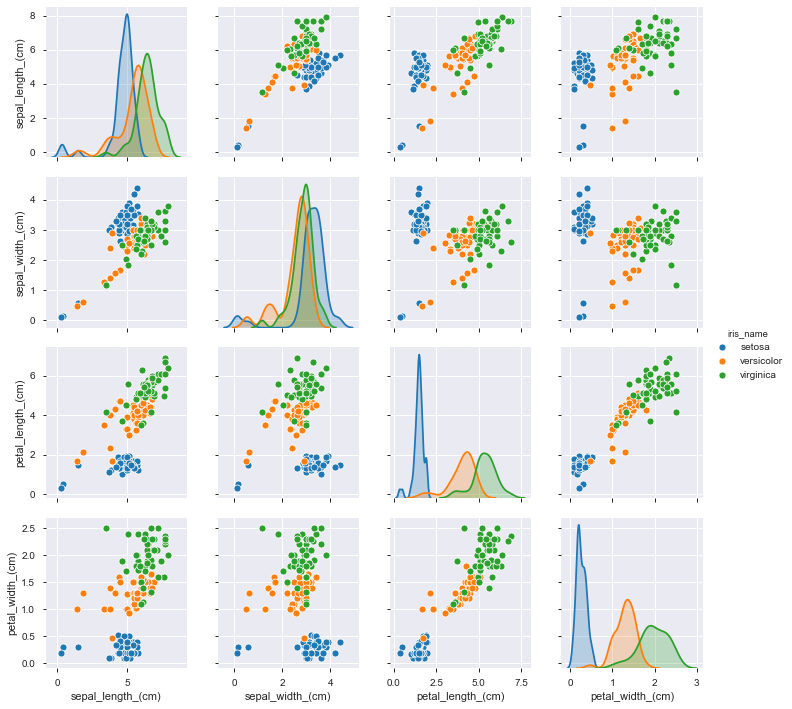

In [34]:
sns.pairplot(convex_optimization_imputed_iris_df, hue='iris_name')

#### BiScalar

In [35]:
biscalar_imputed_iris_df = pd.DataFrame(
    data=BiScaler().fit_transform(missing_data_iris_df.select_dtypes(float).values),
    columns=missing_data_iris_df.select_dtypes(float).columns,
)
biscalar_imputed_iris_df['iris_name'] = iris_df['iris_name'].values

[BiScaler] Initial log residual value = 7.696869
[BiScaler] Iter 1: log residual = 3.548103, log improvement ratio=4.148766
[BiScaler] Iter 2: log residual = 3.904945, log improvement ratio=-0.356842


/usr/local/miniconda3/envs/nb_rubric/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/miniconda3/envs/nb_rubric/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


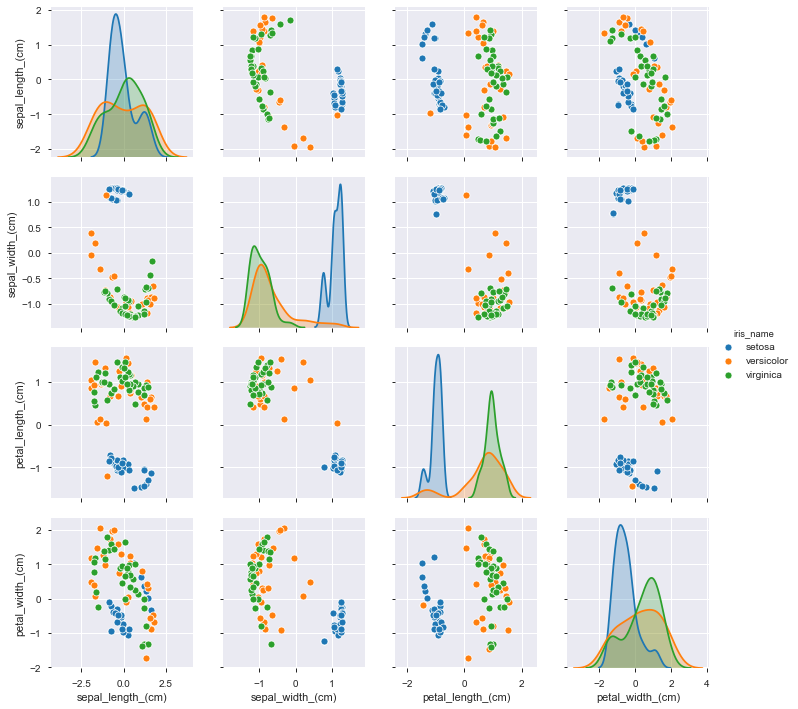

In [36]:
sns.pairplot(biscalar_imputed_iris_df, hue='iris_name')

#### Soft imputation

In [37]:
softimpute_iris_df = pd.DataFrame(
    data=SoftImpute().fit_transform(biscalar_imputed_iris_df.select_dtypes(float).values),
    columns=biscalar_imputed_iris_df.select_dtypes(float).columns,
)
softimpute_iris_df['iris_name'] = iris_df['iris_name'].values

[SoftImpute] Max Singular Value of X_init = 15.123334
[SoftImpute] Iter 1: observed MAE=0.022498 rank=4
[SoftImpute] Iter 2: observed MAE=0.022510 rank=4
[SoftImpute] Iter 3: observed MAE=0.022525 rank=4
[SoftImpute] Iter 4: observed MAE=0.022542 rank=4
[SoftImpute] Iter 5: observed MAE=0.022559 rank=4
[SoftImpute] Iter 6: observed MAE=0.022575 rank=4
[SoftImpute] Iter 7: observed MAE=0.022592 rank=4
[SoftImpute] Iter 8: observed MAE=0.022608 rank=4
[SoftImpute] Iter 9: observed MAE=0.022623 rank=4
[SoftImpute] Iter 10: observed MAE=0.022643 rank=4
[SoftImpute] Iter 11: observed MAE=0.022669 rank=4
[SoftImpute] Iter 12: observed MAE=0.022692 rank=4
[SoftImpute] Iter 13: observed MAE=0.022717 rank=4
[SoftImpute] Iter 14: observed MAE=0.022745 rank=4
[SoftImpute] Iter 15: observed MAE=0.022776 rank=4
[SoftImpute] Iter 16: observed MAE=0.022804 rank=4
[SoftImpute] Iter 17: observed MAE=0.022824 rank=4
[SoftImpute] Iter 18: observed MAE=0.022839 rank=4
[SoftImpute] Iter 19: observed MAE=0.

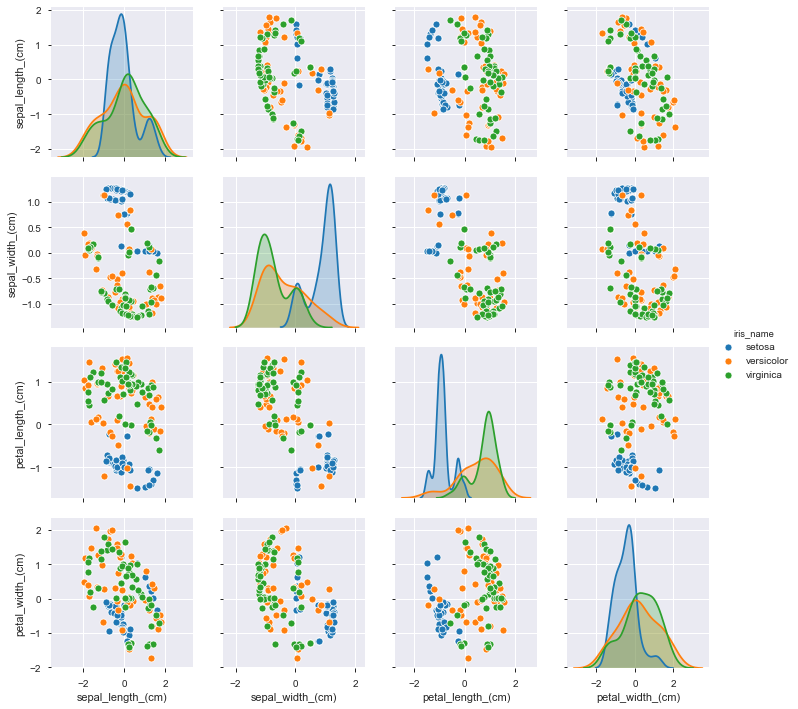

In [38]:
sns.pairplot(softimpute_iris_df, hue='iris_name')

## Model creation
Here we will investigate creating a classifier with the Iris data. We will use
XGBoost for the classifier, but we will use sklearn's GridSearchCV for hyperparameter
optimization.

XGBoost does an excellent job with no hyperparameter adjustments, especially with
the data where there are no missing values. The score with missing values is
less with no hyperparameter adjustments, but still pretty good. The point of
this exercise is to not over inflate the importance of the sixth decimal point of the model,
but to understand the process of creating a model and evaluating how that model
is working. We aren't landing a rover on Mars, so going bananas over lots of
decimal points doesn't really gain anything for us.

We will use the model that performs the worst (from the imputed data)
and then use hyperparameter search to try and make the score better. Always
keep in mind though that garbage data into a model is going to give you
garbage results. **BUT** remember that ultimately the model is wrong, and does not represent
"truth". What we want from the model is to make a decision with the smallest
possible amount of risk when we take an action associated with a model's output.

### No missing data

In [39]:
X = iris_df.select_dtypes(float).values
y = iris_df['iris_name'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
xgb_estimator = xgb.XGBClassifier()
xgb_estimator.fit(X_train, y_train)

predicted_xgb_classifier_df = pd.DataFrame(
    data=xgb_estimator.predict_proba(X_test),
    columns=[f'probability of {iris_name}' for iris_name in xgb_estimator.classes_],
)
predicted_xgb_classifier_df['actual iris name'] = y_test
print(f'Score: {xgb_estimator.score(X_test, y_test)}')
display(predicted_xgb_classifier_df)

Score: 0.9333333333333333


probability of setosa  probability of versicolor  \
0                0.991065                   0.006654   
1                0.011622                   0.110167   
2                0.014686                   0.966536   
3                0.014686                   0.966536   
4                0.991065                   0.006654   
5                0.006644                   0.987555   
6                0.991065                   0.006654   
7                0.991065                   0.006654   
8                0.001916                   0.002456   
9                0.009994                   0.984462   
10               0.001863                   0.002351   
11               0.001983                   0.002541   
12               0.001916                   0.002456   
13               0.007259                   0.986402   
14               0.991065                   0.006654   
15               0.991065                   0.006654   
16               0.983509                   0.014227   
17               0.006141                   0.985611   
18               0.002533                   0.996104   
19               0.026557                   0.656973   
20               0.991065                   0.006654   
21               0.001983                   0.002541   
22               0.005593                   0.989523   
23               0.023690                   0.300715   
24               0.001864                   0.002159   
25               0.001916                   0.002674   
26               0.007259                   0.986402   
27               0.983509                   0.014227   
28               0.001916                   0.002674   
29               0.991065                   0.006654   

    probability of virginica actual iris name  
0                   0.002281           setosa  
1                   0.878210        virginica  
2                   0.018778       versicolor  
3                   0.018778       versicolor  
4                   0.002281           setosa  
5                   0.005802       versicolor  
6                   0.002281           setosa  
7                   0.002281           setosa  
8                   0.995628        virginica  
9                   0.005544       versicolor  
10                  0.995786        virginica  
11                  0.995476        virginica  
12                  0.995628        virginica  
13                  0.006339       versicolor  
14                  0.002281           setosa  
15                  0.002281           setosa  
16                  0.002264           setosa  
17                  0.008247       versicolor  
18                  0.001362       versicolor  
19                  0.316469        virginica  
20                  0.002281           setosa  
21                  0.995476        virginica  
22                  0.004884       versicolor  
23                  0.675595        virginica  
24                  0.995977        virginica  
25                  0.995410       versicolor  
26                  0.006339       versicolor  
27                  0.002264           setosa  
28                  0.995410        virginica  
29                  0.002281           setosa

### With missing data

In [40]:
X = missing_data_iris_df.select_dtypes(float).values
y = missing_data_iris_df['iris_name'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
missing_data_xgb_estimator = xgb.XGBClassifier()
missing_data_xgb_estimator.fit(X_train, y_train)
predicted_missing_data_classifier_df = pd.DataFrame(
    data=missing_data_xgb_estimator.predict_proba(X_test),
    columns=[f'probability of {iris_name}' for iris_name in missing_data_xgb_estimator.classes_],
)
predicted_missing_data_classifier_df['actual iris name'] = y_test
print(missing_data_xgb_estimator.score(X_test, y_test))
display(predicted_missing_data_classifier_df)

0.9


probability of setosa  probability of versicolor  \
0                0.983999                   0.011447   
1                0.301347                   0.482388   
2                0.024695                   0.965471   
3                0.017869                   0.969452   
4                0.996757                   0.002236   
5                0.008625                   0.978630   
6                0.991463                   0.006444   
7                0.994881                   0.004030   
8                0.000798                   0.001961   
9                0.007543                   0.978760   
10               0.002183                   0.008618   
11               0.000968                   0.001960   
12               0.000798                   0.001961   
13               0.010006                   0.982506   
14               0.992624                   0.006229   
15               0.987354                   0.009559   
16               0.915036                   0.081087   
17               0.002762                   0.994891   
18               0.001390                   0.996611   
19               0.288603                   0.504277   
20               0.995949                   0.002793   
21               0.002086                   0.003244   
22               0.003996                   0.957596   
23               0.008254                   0.442469   
24               0.000920                   0.001957   
25               0.001746                   0.009759   
26               0.003684                   0.951684   
27               0.983010                   0.012670   
28               0.002057                   0.002597   
29               0.995949                   0.002793   

    probability of virginica actual iris name  
0                   0.004554           setosa  
1                   0.216266        virginica  
2                   0.009834       versicolor  
3                   0.012679       versicolor  
4                   0.001007           setosa  
5                   0.012745       versicolor  
6                   0.002093           setosa  
7                   0.001088           setosa  
8                   0.997241        virginica  
9                   0.013697       versicolor  
10                  0.989199        virginica  
11                  0.997072        virginica  
12                  0.997241        virginica  
13                  0.007487       versicolor  
14                  0.001147           setosa  
15                  0.003087           setosa  
16                  0.003878           setosa  
17                  0.002347       versicolor  
18                  0.001999       versicolor  
19                  0.207120        virginica  
20                  0.001258           setosa  
21                  0.994670        virginica  
22                  0.038408       versicolor  
23                  0.549277        virginica  
24                  0.997123        virginica  
25                  0.988495       versicolor  
26                  0.044632       versicolor  
27                  0.004320           setosa  
28                  0.995346        virginica  
29                  0.001258           setosa

### With imputed data (mean)
Here we see the effect of imputed data on the model creation

In [41]:
X = imputed_data_iris_df.select_dtypes(float).values
y = imputed_data_iris_df['iris_name'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
mean_imputed_xgb_estimator = xgb.XGBClassifier()
mean_imputed_xgb_estimator.fit(X_train, y_train)
predicted_mean_imputed_xgb_classifier_df = pd.DataFrame(
    data=mean_imputed_xgb_estimator.predict_proba(X_test),
    columns=[f'probability of {iris_name}' for iris_name in mean_imputed_xgb_estimator.classes_],
)
predicted_mean_imputed_xgb_classifier_df['actual iris name'] = y_test
print(mean_imputed_xgb_estimator.score(X_test, y_test))
display(predicted_mean_imputed_xgb_classifier_df)

0.9


probability of setosa  probability of versicolor  \
0                0.952725                   0.041944   
1                0.043541                   0.940793   
2                0.146592                   0.841304   
3                0.107065                   0.881556   
4                0.996817                   0.002335   
5                0.003574                   0.985690   
6                0.994568                   0.004190   
7                0.995762                   0.003181   
8                0.000847                   0.002598   
9                0.006344                   0.980244   
10               0.001453                   0.015405   
11               0.002326                   0.002594   
12               0.000847                   0.002598   
13               0.034897                   0.934094   
14               0.989187                   0.009145   
15               0.993981                   0.004471   
16               0.978361                   0.019128   
17               0.009160                   0.983867   
18               0.002492                   0.992997   
19               0.043541                   0.940793   
20               0.996760                   0.002392   
21               0.001116                   0.003819   
22               0.002469                   0.536750   
23               0.008966                   0.309110   
24               0.000847                   0.002598   
25               0.001046                   0.010217   
26               0.002030                   0.941494   
27               0.995762                   0.003181   
28               0.000900                   0.008798   
29               0.996760                   0.002392   

    probability of virginica actual iris name  
0                   0.005331           setosa  
1                   0.015666        virginica  
2                   0.012104       versicolor  
3                   0.011379       versicolor  
4                   0.000848           setosa  
5                   0.010737       versicolor  
6                   0.001242           setosa  
7                   0.001056           setosa  
8                   0.996554        virginica  
9                   0.013412       versicolor  
10                  0.983142        virginica  
11                  0.995080        virginica  
12                  0.996554        virginica  
13                  0.031008       versicolor  
14                  0.001668           setosa  
15                  0.001548           setosa  
16                  0.002511           setosa  
17                  0.006973       versicolor  
18                  0.004511       versicolor  
19                  0.015666        virginica  
20                  0.000848           setosa  
21                  0.995066        virginica  
22                  0.460781       versicolor  
23                  0.681924        virginica  
24                  0.996554        virginica  
25                  0.988738       versicolor  
26                  0.056476       versicolor  
27                  0.001056           setosa  
28                  0.990302        virginica  
29                  0.000848           setosa

### Imputed data KNN

In [42]:
X = knn_imputed_iris_df.select_dtypes(float).values
y = knn_imputed_iris_df['iris_name'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
knn_imputed_xgb_estimator = xgb.XGBClassifier()
knn_imputed_xgb_estimator.fit(X_train, y_train)
prdicted_knn_imputed_xgb_classifier_df = pd.DataFrame(
    data=knn_imputed_xgb_estimator.predict_proba(X_test),
    columns=[f'probability of {iris_name}' for iris_name in knn_imputed_xgb_estimator.classes_],
)
prdicted_knn_imputed_xgb_classifier_df['actual iris name'] = y_test
print(knn_imputed_xgb_estimator.score(X_test, y_test))
display(prdicted_knn_imputed_xgb_classifier_df)

0.8


probability of setosa  probability of versicolor  \
0                0.985102                   0.009284   
1                0.008123                   0.980159   
2                0.008571                   0.986919   
3                0.010265                   0.984041   
4                0.996442                   0.001897   
5                0.004247                   0.988008   
6                0.996442                   0.001897   
7                0.996442                   0.001897   
8                0.002243                   0.020108   
9                0.006033                   0.983082   
10               0.004252                   0.057918   
11               0.002249                   0.007185   
12               0.001446                   0.006373   
13               0.037039                   0.801401   
14               0.996442                   0.001897   
15               0.457320                   0.000767   
16               0.996442                   0.001897   
17               0.008576                   0.987519   
18               0.002123                   0.994183   
19               0.028111                   0.936307   
20               0.996442                   0.001897   
21               0.006305                   0.006486   
22               0.002085                   0.887665   
23               0.010108                   0.574512   
24               0.001448                   0.004437   
25               0.001956                   0.005747   
26               0.005936                   0.358124   
27               0.996442                   0.001897   
28               0.004396                   0.103025   
29               0.996442                   0.001897   

    probability of virginica actual iris name  
0                   0.005614           setosa  
1                   0.011718        virginica  
2                   0.004510       versicolor  
3                   0.005694       versicolor  
4                   0.001661           setosa  
5                   0.007745       versicolor  
6                   0.001661           setosa  
7                   0.001661           setosa  
8                   0.977649        virginica  
9                   0.010885       versicolor  
10                  0.937830        virginica  
11                  0.990566        virginica  
12                  0.992182        virginica  
13                  0.161560       versicolor  
14                  0.001661           setosa  
15                  0.541913           setosa  
16                  0.001661           setosa  
17                  0.003904       versicolor  
18                  0.003694       versicolor  
19                  0.035582        virginica  
20                  0.001661           setosa  
21                  0.987209        virginica  
22                  0.110251       versicolor  
23                  0.415380        virginica  
24                  0.994115        virginica  
25                  0.992297       versicolor  
26                  0.635939       versicolor  
27                  0.001661           setosa  
28                  0.892578        virginica  
29                  0.001661           setosa

### Imputed convex optimization

In [43]:
X = convex_optimization_imputed_iris_df.select_dtypes(float).values
y = convex_optimization_imputed_iris_df['iris_name'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
convex_optimization_xgb_estimator = xgb.XGBClassifier()
convex_optimization_xgb_estimator.fit(X_train, y_train)
predicted_convex_optimization_classifier_df = pd.DataFrame(
    data=convex_optimization_xgb_estimator.predict_proba(X_test),
    columns=[f'probability of {iris_name}' for iris_name in convex_optimization_xgb_estimator.classes_],
)
predicted_convex_optimization_classifier_df['actual iris name'] = y_test
print(convex_optimization_xgb_estimator.score(X_test, y_test))
display(predicted_convex_optimization_classifier_df)

0.8666666666666667


probability of setosa  probability of versicolor  \
0                0.996131                   0.002261   
1                0.062425                   0.861637   
2                0.005517                   0.986504   
3                0.007535                   0.980491   
4                0.996046                   0.002347   
5                0.007143                   0.925828   
6                0.996082                   0.002310   
7                0.995943                   0.002408   
8                0.001335                   0.002970   
9                0.004381                   0.990063   
10               0.001852                   0.005578   
11               0.001335                   0.003082   
12               0.001335                   0.002970   
13               0.004425                   0.970270   
14               0.961759                   0.036598   
15               0.995692                   0.002557   
16               0.996014                   0.002378   
17               0.004536                   0.988973   
18               0.001235                   0.996634   
19               0.063050                   0.870266   
20               0.996082                   0.002310   
21               0.001213                   0.002421   
22               0.002132                   0.972048   
23               0.012273                   0.505625   
24               0.001339                   0.005656   
25               0.008490                   0.035876   
26               0.004560                   0.911130   
27               0.995911                   0.002440   
28               0.001335                   0.002970   
29               0.996082                   0.002310   

    probability of virginica actual iris name  
0                   0.001608           setosa  
1                   0.075939        virginica  
2                   0.007979       versicolor  
3                   0.011973       versicolor  
4                   0.001608           setosa  
5                   0.067029       versicolor  
6                   0.001608           setosa  
7                   0.001649           setosa  
8                   0.995694        virginica  
9                   0.005557       versicolor  
10                  0.992570        virginica  
11                  0.995583        virginica  
12                  0.995694        virginica  
13                  0.025305       versicolor  
14                  0.001643           setosa  
15                  0.001751           setosa  
16                  0.001608           setosa  
17                  0.006491       versicolor  
18                  0.002132       versicolor  
19                  0.066683        virginica  
20                  0.001608           setosa  
21                  0.996366        virginica  
22                  0.025821       versicolor  
23                  0.482102        virginica  
24                  0.993005        virginica  
25                  0.955634       versicolor  
26                  0.084310       versicolor  
27                  0.001649           setosa  
28                  0.995694        virginica  
29                  0.001608           setosa

### Imputed BiScalar

In [44]:
X = biscalar_imputed_iris_df.select_dtypes(float).values
y = biscalar_imputed_iris_df['iris_name'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
biscalar_xgb_estimator = xgb.XGBClassifier()
biscalar_xgb_estimator.fit(X_train, y_train)
predicted_biscalar_xgb_classifier_df = pd.DataFrame(
    data=biscalar_xgb_estimator.predict_proba(X_test),
    columns=[f'probability of {iris_name}' for iris_name in biscalar_xgb_estimator.classes_],
)
predicted_biscalar_xgb_classifier_df['actual iris name'] = y_test
print(biscalar_xgb_estimator.score(X_test, y_test))
display(predicted_biscalar_xgb_classifier_df)

0.6333333333333333


probability of setosa  probability of versicolor  \
0                0.988408                   0.010784   
1                0.012962                   0.952164   
2                0.004458                   0.196960   
3                0.007233                   0.913462   
4                0.910611                   0.088349   
5                0.012693                   0.902828   
6                0.988408                   0.010784   
7                0.986371                   0.011179   
8                0.001769                   0.024358   
9                0.007516                   0.964892   
10               0.030882                   0.671115   
11               0.041058                   0.614971   
12               0.001681                   0.051173   
13               0.002778                   0.071873   
14               0.882887                   0.107089   
15               0.975343                   0.022360   
16               0.900718                   0.096195   
17               0.002786                   0.198564   
18               0.001182                   0.651253   
19               0.012962                   0.952164   
20               0.997242                   0.001793   
21               0.012693                   0.902828   
22               0.010222                   0.078549   
23               0.001233                   0.636324   
24               0.005964                   0.343365   
25               0.005677                   0.590944   
26               0.008921                   0.959864   
27               0.997122                   0.001913   
28               0.002199                   0.696072   
29               0.997513                   0.001522   

    probability of virginica actual iris name  
0                   0.000808           setosa  
1                   0.034874        virginica  
2                   0.798582       versicolor  
3                   0.079305       versicolor  
4                   0.001040           setosa  
5                   0.084479       versicolor  
6                   0.000808           setosa  
7                   0.002450           setosa  
8                   0.973872        virginica  
9                   0.027593       versicolor  
10                  0.298003        virginica  
11                  0.343972        virginica  
12                  0.947146        virginica  
13                  0.925349       versicolor  
14                  0.010024           setosa  
15                  0.002296           setosa  
16                  0.003087           setosa  
17                  0.798650       versicolor  
18                  0.347565       versicolor  
19                  0.034874        virginica  
20                  0.000965           setosa  
21                  0.084479        virginica  
22                  0.911229       versicolor  
23                  0.362443        virginica  
24                  0.650671        virginica  
25                  0.403379       versicolor  
26                  0.031215       versicolor  
27                  0.000965           setosa  
28                  0.301729        virginica  
29                  0.000965           setosa

### Soft imputation

In [45]:
X = softimpute_iris_df.select_dtypes(float).values
y = softimpute_iris_df['iris_name'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
softimpute_xgb_estimator = xgb.XGBClassifier()
softimpute_xgb_estimator.fit(X_train, y_train)
predicted_softimpute_xgb_classifier_df = pd.DataFrame(
    data=softimpute_xgb_estimator.predict_proba(X_test),
    columns=[f'probability of {iris_name}' for iris_name in softimpute_xgb_estimator.classes_],
)
predicted_softimpute_xgb_classifier_df['actual iris name'] = y_test
print(softimpute_xgb_estimator.score(X_test, y_test))
display(predicted_softimpute_xgb_classifier_df)

0.6666666666666666


probability of setosa  probability of versicolor  \
0                0.970575                   0.026699   
1                0.278236                   0.671126   
2                0.003118                   0.132717   
3                0.004619                   0.431871   
4                0.902726                   0.094515   
5                0.016072                   0.922740   
6                0.969743                   0.027533   
7                0.989440                   0.008984   
8                0.002008                   0.068503   
9                0.005799                   0.539893   
10               0.008621                   0.675142   
11               0.013463                   0.417786   
12               0.002440                   0.072052   
13               0.004007                   0.262372   
14               0.845682                   0.141179   
15               0.952751                   0.039805   
16               0.818567                   0.162015   
17               0.003840                   0.252100   
18               0.003003                   0.244055   
19               0.446931                   0.512818   
20               0.994670                   0.003746   
21               0.002804                   0.946650   
22               0.007111                   0.409468   
23               0.005562                   0.161739   
24               0.004581                   0.101698   
25               0.004418                   0.599047   
26               0.004477                   0.875510   
27               0.985060                   0.013326   
28               0.002587                   0.274459   
29               0.994234                   0.004053   

    probability of virginica actual iris name  
0                   0.002726           setosa  
1                   0.050638        virginica  
2                   0.864165       versicolor  
3                   0.563511       versicolor  
4                   0.002759           setosa  
5                   0.061188       versicolor  
6                   0.002724           setosa  
7                   0.001575           setosa  
8                   0.929489        virginica  
9                   0.454308       versicolor  
10                  0.316237        virginica  
11                  0.568751        virginica  
12                  0.925507        virginica  
13                  0.733621       versicolor  
14                  0.013139           setosa  
15                  0.007444           setosa  
16                  0.019418           setosa  
17                  0.744059       versicolor  
18                  0.752942       versicolor  
19                  0.040251        virginica  
20                  0.001584           setosa  
21                  0.050546        virginica  
22                  0.583421       versicolor  
23                  0.832699        virginica  
24                  0.893721        virginica  
25                  0.396535       versicolor  
26                  0.120013       versicolor  
27                  0.001614           setosa  
28                  0.722954        virginica  
29                  0.001713           setosa

## Model hyperparameter search

In [56]:
cross_validation_folds = 3
hyperparameter_grid = [
    {
        'base_score': [0.1, 1],
        'colsample_bylevel': [1],
        'colsample_bytree': [1],
        'gamma': [0],
        'learning_rate': [0.1],
        'max_delta_step': [0],
        'max_depth': [3, 5],
        'min_child_weight': [1],
        'n_estimators': [100, 500],
        'reg_alpha': [0, 2, 4],
        'reg_lambda': [1, 2, 4],
        'scale_pos_weight': [1, 2],
        'subsample': [0.001, 0.01, 0.1],
    }
]
clf = GridSearchCV(
    estimator=softimpute_xgb_estimator,
    param_grid=hyperparameter_grid,
    cv=cross_validation_folds,
#     verbose=10,
)
clf.fit(X_train, y_train)

/usr/local/miniconda3/envs/nb_rubric/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bytree=1,
                                     gamma=0, learning_rate=0.1,
                                     max_delta_step=0, max_depth=3,
                                     min_child_weight=1, missing=None,
                                     n_estimators=100, n_jobs=1, nthread=None,
                                     objective='multi:softprob', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_we...
             param_grid=[{'base_score': [0.1, 1], 'colsample_bylevel': [1],
                          'colsample_bytree': [1], 'gamma': [0],
                          'learning_rate': [0.1], 'max_delta_step': [0],
                          'max_depth': [3, 5], 'min_child_weight': [1],
                          'n_est

In [57]:
clf.best_score_, clf.best_params_

(0.6333333333333333,
 {'base_score': 0.1,
  'colsample_bylevel': 1,
  'colsample_bytree': 1,
  'gamma': 0,
  'learning_rate': 0.1,
  'max_delta_step': 0,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 500,
  'reg_alpha': 2,
  'reg_lambda': 2,
  'scale_pos_weight': 1,
  'subsample': 0.1})

In [58]:
best_estimator = xgb.XGBClassifier(**clf.best_params_)
best_estimator.fit(X_train, y_train)
best_estimator_df = pd.DataFrame(
    data=best_estimator.predict_proba(X_test),
    columns=[f'probability of {iris_name}' for iris_name in best_estimator.classes_],
)
best_estimator_df['actual iris name'] = y_test
print(best_estimator.score(X_test, y_test))
display(best_estimator_df)

0.6666666666666666


probability of setosa  probability of versicolor  \
0                0.730139                   0.181788   
1                0.343365                   0.431214   
2                0.191132                   0.474468   
3                0.128379                   0.542795   
4                0.716604                   0.195583   
5                0.176013                   0.408293   
6                0.717532                   0.196202   
7                0.756340                   0.156764   
8                0.086501                   0.277258   
9                0.115181                   0.416778   
10               0.148480                   0.421165   
11               0.110329                   0.348512   
12               0.089302                   0.305678   
13               0.112176                   0.352613   
14               0.510122                   0.310313   
15               0.677048                   0.227543   
16               0.526541                   0.330218   
17               0.088690                   0.318480   
18               0.086649                   0.405609   
19               0.498329                   0.338548   
20               0.765999                   0.148693   
21               0.164281                   0.423991   
22               0.214223                   0.455726   
23               0.089809                   0.387997   
24               0.151037                   0.427501   
25               0.112853                   0.433527   
26               0.135335                   0.454258   
27               0.732340                   0.178590   
28               0.086788                   0.405123   
29               0.768890                   0.147972   

    probability of virginica actual iris name  
0                   0.088073           setosa  
1                   0.225421        virginica  
2                   0.334400       versicolor  
3                   0.328826       versicolor  
4                   0.087812           setosa  
5                   0.415694       versicolor  
6                   0.086266           setosa  
7                   0.086896           setosa  
8                   0.636240        virginica  
9                   0.468041       versicolor  
10                  0.430355        virginica  
11                  0.541159        virginica  
12                  0.605021        virginica  
13                  0.535211       versicolor  
14                  0.179565           setosa  
15                  0.095409           setosa  
16                  0.143241           setosa  
17                  0.592830       versicolor  
18                  0.507742       versicolor  
19                  0.163123        virginica  
20                  0.085308           setosa  
21                  0.411728        virginica  
22                  0.330051       versicolor  
23                  0.522195        virginica  
24                  0.421462        virginica  
25                  0.453621       versicolor  
26                  0.410408       versicolor  
27                  0.089070           setosa  
28                  0.508089        virginica  
29                  0.083137           setosa

## Model evaluation

### ROC and learning curves

In [59]:
X = softimpute_iris_df.select_dtypes(float).values
y = softimpute_iris_df['iris_name'].values
def plot_learning_curve(estimator, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title('Learning curve')
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    # Adding the number of classes to the XGBoost estimator since it doesn't
    # do it automatically using the cross-validation scheme needed for the
    # learning curve.
    estimator_parameters = estimator.get_xgb_params()
    estimator_parameters['num_class'] = 3
    estimator.set_params(**estimator_parameters)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(
        train_sizes,
        train_scores_mean,
        'o-',
        color="r",
        label="Training score",
    )
    plt.plot(
        train_sizes,
        test_scores_mean,
        'o-',
        color="g",
        label="Cross-validation score",
    )
    plt.legend(loc="best")
    return plt

### Learning curves
The learning curve shows you where you can truncate training examples for the optimized
model.

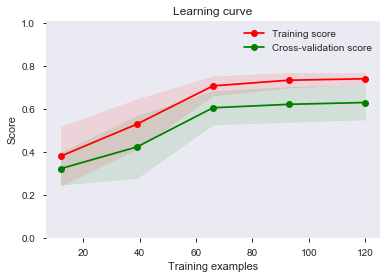

In [60]:
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=RANDOM_STATE)

plot_learning_curve(best_estimator, X, y, ylim=(0.0, 1.01), cv=cv, n_jobs=4)
plt.show()

### Receiver operator characteristic (ROC) curve
The ROC curve is typically used for binary classification to determine the model's
true positive rate _vs_ its false positive rate classification. In the case of the
Iris data set we have three classes. This means that the ROC curve is not so useful
for evaluating the model. However, if you need to create a ROC curve for a multiclassification
problem, then you can make a classifier for all classes, and then calculate the
true positive classifications and false positive classifications.

See the documentation from sklearn for an example using the Iris data set
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

### Confusion matrix
Since we are making a classifier, we can visualize how the classifier is not
correctly classifying items using a confusion matrix. This is exactly like
the heatmap used above to visualize correlations between features, only now
the intent of the visual is to show how the classifier is performing

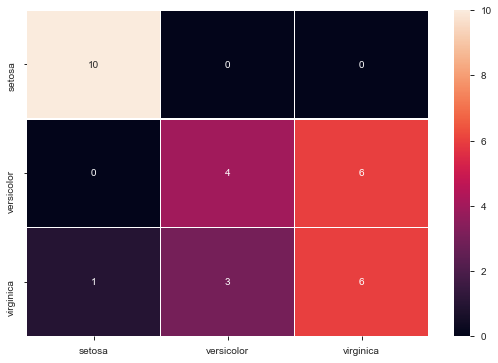

In [61]:
y_predicted = best_estimator.predict(X_test)
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(
    pd.DataFrame(
        data=confusion_matrix(y_test, y_predicted),
        columns=best_estimator.classes_,
        index=best_estimator.classes_,
    ),
    annot=True,
    linewidths=.5,
    ax=ax,
)

### Posterior predictive checks
Sometimes you will have the bandwidth to do some white-box modeling, and if you're
lucky you can do some Bayesian analysis. If you have that opportunity you will still
need to evaluate your model using posterior predictive checks. For an example of
how some PPC visuals can be made using python, bokeh and stan see
https://github.com/amaloney/stancon2018_intro/blob/feature/add_jupyter_notebooks/intro/jupyter/StanCon2018%20Intro-Python3.ipynb

## Results
The results section should go into further depth than the executive summary above.
This is basically your conclusions about the analysis, model evaluation, and insights
associated with task at hand. It should go into enough depth for your colleagues
and not necessarily a business executive.

Summarize all your key findings and any further actions that should be taken.
If needed, map out how to turn your analysis into an actual product that can be
used for predictions or classifications, _etc_.